<a href="https://colab.research.google.com/github/changw121/Best-websites-a-programmer-should-visit/blob/master/pyG%E5%B0%8F%E5%AE%9E%E6%88%9801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pyG中的数据处理、数据集、加载器和转换
使用GCN层
在Cora引文数据集上实验

In [1]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=00e3bade2d43a64121d6ac36f3d17eb11528646747a9cd4acea7fa35db30328e
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 68.9 MB/s eta 0:00:00


# Cora数据集介绍

该数据集**共2708个样本点**，每个样本点都是一篇科学论文，**所有样本点被分为7个类别**，类别分别是1）基于案例；2）遗传算法；3）神经网络；4）概率方法；5）强化学习；6）规则学习；7）理论。

每篇论文都由一个**1433维**的词向量表示，所以，**每个样本点具有1433个特征**。词向量的每个元素都对应一个词，且该元素只有0或1两种取值。取0表示该元素对应的词不在论文中，取1表示在论文中。所有的词来源于一个具有1433个词的字典。？？？

每篇论文都至少引用了一篇其他论文，或者被其他论文引用，也就是样本点之间存在联系，没有任何一个样本点与其他样本点完全没联系。如果将样本点看作图中的点，则**这是一个连通的图，不存在孤立点**。

数据集主要文件有两个：cora.cites, cora.content。其中，cora.content包含了2708个样本的具体信息，每行代表一个论文样本，格式为
<论文id>  <由01组成的1433维特征>  <论文类别（label）>？？？

总的来说，如果将论文当作“图”的节点，则引用关系则为“图”的边，论文节点信息和引用关系共同构成了图数据。

本次实验，我们将利用这些信息，**对论文所属的类别进行预测**，完成关于论文类别的分类任务。

In [2]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [3]:
dataset

Cora()

In [4]:
len(dataset) # 1表示只包含一个graph

1

In [8]:
dataset[0].is_undirected() # 第一个图是无向图

True

In [5]:
dataset[0] # 通过索引的方式来访问数据集中的数据：第一个图包含有2708个结点，每个结点特征维度为1433，10556/2=5278条无向边，train_mask是训练集的mask向量，标识哪些节点属于训练集。val_mask验证集。test_mask是测试集。y是节点的标签维度。

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
dataset.num_node_features # 节点特征维度为1433

1433

In [ ]:
dataset.num_classes #节点类别个数为7

7

In [ ]:
dataset[0].y.unique() #一共多少种类别

tensor([0, 1, 2, 3, 4, 5, 6])

# node-level prediction 节点分类任务
1. 模型搭建（实现两层GCN）

```from torch_geometric.nn import GCNConv```

模型参数：


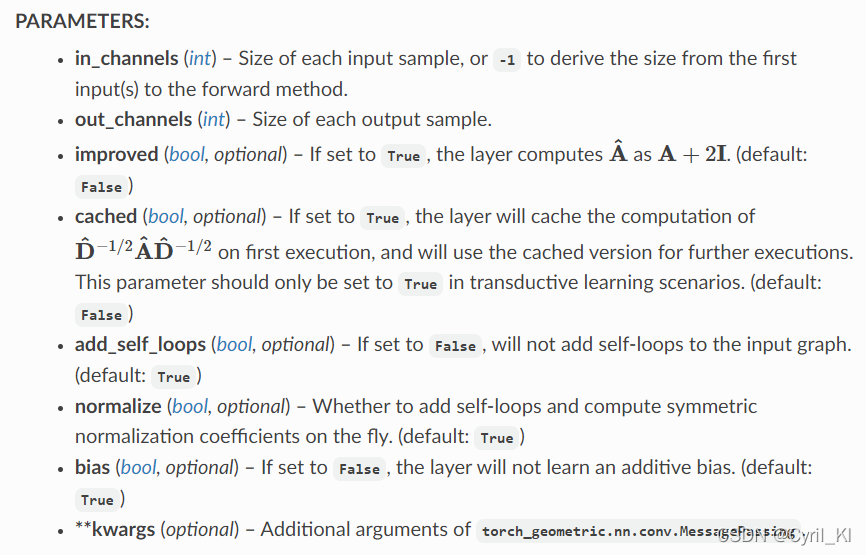

**in_channels**：输入通道，比如节点分类中表示每个节点的特征数。

**out_channels**：输出通道，最后一层GCNConv的输出通道为节点类别数（节点分类）。

improved：如果为True表示自环增加，也就是原始邻接矩阵加上2I而不是I，默认为False。

cached：如果为True，GCNConv在第一次对邻接矩阵进行归一化时会进行缓存，以后将不再重复计算。

add_self_loops：如果为False不再强制添加自环，默认为True。

normalize：默认为True，表示对邻接矩阵进行归一化。

bias：默认添加偏置。


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module): # 继承Module
    def __init__(self): # 定义所有网络层。self含义：一般情况下，一个函数的变量不可以床底给另外的函数，使用self后可以将这个变量传递给后面的函数
        super().__init__() # 继承父类
        self.conv1 = GCNConv(dataset.num_node_features, 16) # 输入维度是每个节点的特征数目 # 16是中间隐藏层的维度
        self.conv2 = GCNConv(16, dataset.num_classes) # 输出的是类别数

    def forward(self, data): # 前向函数，输入是data
        # 加载结点特征和邻接关系
        x, edge_index = data.x, data.edge_index
        # 传入卷积层
        x = self.conv1(x, edge_index)
        x = F.relu(x) # 激活函数
        x = F.dropout(x, training=self.training) # dropout层，防止过拟合
        x = self.conv2(x, edge_index) # 第二层卷积层

        return F.log_softmax(x, dim=1) # 将经过两层卷积得到的特征输入log_softmax函数得到概率分布

2. 训练模型

In [ ]:
from torch.optim import optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU
model = GCN().to(device) # 构建模型
data = dataset[0].to(device) # 加载数据
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # 定义优化函数

In [ ]:
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
model.train()
for epoch in range(100): # 该模型训练100个epoch，loss函数使用null_loss
    optimizer.zero_grad() # 梯度设为零
    out = model(data) # 模型输出
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # 计算损失
    loss.backward() # 反向传播计算梯度
    optimizer.step() # 一步优化，更新参数

    if epoch%10 == 0:
      print(f'epoch:{epoch}, loss:{loss}, acc:{accuracy_score(data.y[data.val_mask].cpu(), out.argmax(dim=1)[data.val_mask].cpu())}')

epoch:0, loss:1.9568045139312744, acc:0.186
epoch:10, loss:0.9536699652671814, acc:0.542
epoch:20, loss:0.3142772614955902, acc:0.718
epoch:30, loss:0.11366307735443115, acc:0.716
epoch:40, loss:0.06791705638170242, acc:0.732
epoch:50, loss:0.05593932047486305, acc:0.72
epoch:60, loss:0.04146436229348183, acc:0.744
epoch:70, loss:0.04927568882703781, acc:0.76
epoch:80, loss:0.033658694475889206, acc:0.752
epoch:90, loss:0.04601650685071945, acc:0.72


3. 在测试集结点上评估模型

In [ ]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
model.eval() # 评估模型
pred = model(data).argmax(dim=1) # 得到模型输出的类别
acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu()) # 得出准确率
prec = precision_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),average="macro")
rec = recall_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),average="macro")
f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),average="macro")
print("The accuracy is: ",acc)
print("The precision is: ",prec)
print("The recall is: ",rec)
print("The f1 is: ",f1)

The accuracy is:  0.807
The precision is:  0.7927584796180814
The recall is:  0.8207062754455122
The f1 is:  0.801821797542347


# 补充知识点

1. 数据存放目录：

如果加载数据出现问题，可以自行下载数据并创建文件夹，将data中有关cora的数据放在下图所示的目录中：

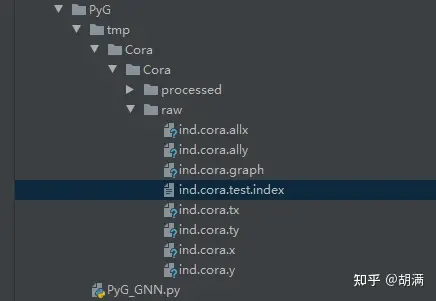

2. model.train()和model.eval()的含义：

这两个函数分别定义模型的训练模式和测试模式，主要对Dropout层和BatchNorm产生影响，主要影响如下:

Dropout: 训练过程中，为防止模型过拟合，增加其泛化性，会随机屏蔽掉一些神经元，相当于输入每次经过不同的神经元，最终得到不同的模型。测试模式时，所有神经元共同作用，类似于boosting。

BatchNorm: 训练过程中，模型每次处理一个minibatch数据，BN层根据一个minibatch来计算mean和std后做归一化处理。测试时，BN层会利用训练时得到的参数来处理测试数据。如果不设置model.eval()，输入单个数据，模型会报错。

3. ReLu()函数
在多层神经网络中，上层节点的输出和下层节点的输入之间具有一个函数关系，这个函数称为激活函数。

4. 前向传播


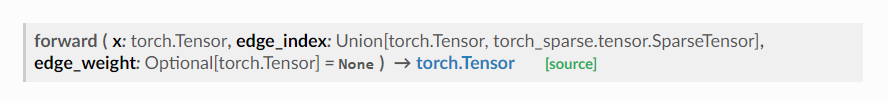

GCNConv中需要输入的是节点特征矩阵x和邻接关系edge_index，还有一个可选项edge_weight。

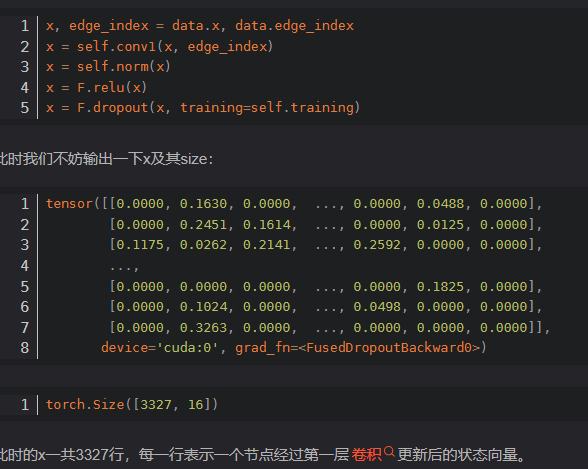

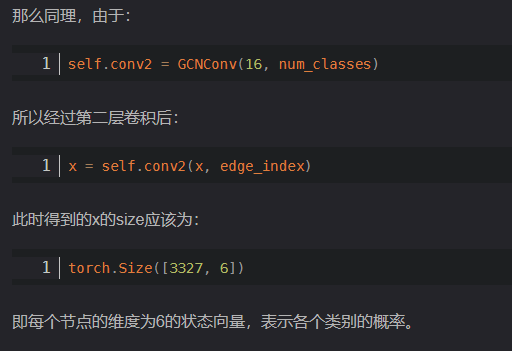

5. 反向传播
